# SHRED for ROMs: interpolation - sensors UQ

We first randomly select 3 sensor locations and set the trajectory length (lags) to 52, which is hyperparameter tuned.

In [170]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pickle
import pandas as pd

_, is_vector, times = pickle.load(open('msfr_uloff.set', 'rb'))
times = np.array(times)

path_svd = './OfflineSVD/'
u_total = pickle.load(open(path_svd+'u_total.svd', 'rb'))
v_total = pickle.load(open(path_svd+'v_total.svd', 'rb'))
s_total = pickle.load(open(path_svd+'s_total.svd', 'rb'))

var_names = pickle.load(open(path_svd+"var.names", 'rb'))
rescaling_snaps = pickle.load(open(path_svd+"rescaling.svd", 'rb'))
Nmodes = pickle.load(open(path_svd+"Nmodes.svd", 'rb'))

measure = 'outcore-random' # 'outcore-random', 'incore-random', 'outcore-eim
if measure == 'incore-random':
  measurements = pickle.load(open(path_svd+'measurements_incore.data', 'rb'))
elif measure == 'outcore-eim':
  measurements = pickle.load(open(path_svd+'measurements_EIM.data', 'rb'))
else:
  measurements = pickle.load(open(path_svd+'measurements_3.data', 'rb'))
  # measurements = pickle.load(open(path_svd+'measurements_10.data', 'rb'))

Let us extract the number of modes

In [2]:
Nvariables = len(var_names)
n_configurations = measurements['location'].shape[1]
num_sensors = measurements['noisy_output'].shape[0]

assert measurements['noisy_output'].shape[2] == n_configurations

Ns = measurements['noisy_output'].shape[1]
new_t = np.linspace(times[0], times[-1], Ns)

Let us define the tex variables

In [3]:
energy_groups = 6
tex_var_names = [r'\phi_'+str(g+1) for g in range(energy_groups)]

prec_groups = 8
tex_var_names.extend([r'c_'+str(g+1) for g in range(prec_groups)])

dec_groups = 3
tex_var_names.extend([r'd_'+str(g+1) for g in range(dec_groups)])

tex_var_names.extend(['T', 'p', r'\mathbf{u}'])

assert len(tex_var_names) == len(var_names)

Here the necessary packages for SHRED are loaded

In [4]:
import sys
sys.path.append('../../') # to include the SHRED modules

from shred.processdata import TimeSeriesDataset
import shred.models as models
import torch
from sklearn.preprocessing import MinMaxScaler
import os

if measure == 'incore-random':
    path_shred = './SHRED/InCore/'
elif measure == 'outcore-eim':
    path_shred = './SHRED/EIM/'
else:
    path_shred = './SHRED/'
    
if not os.path.exists(path_shred):
    os.makedirs(path_shred)

## Training the SHRED models
For each sensor, a SHRED net is trained. 

Choose either MPS or cuda according to your device

In [5]:
from IPython.display import clear_output

lags = 52
_load_X = v_total.T
sensor_locations = np.arange(0, num_sensors, 1, dtype=int) # [0,1,2]

shred = list()
test_datasets = list()

train_net = True

# Reconstruction - splitting into train, test and validation
np.random.seed(42)
train_indices = np.random.choice(Ns - lags, size=350, replace=False)
mask = np.ones(Ns - lags)
mask[train_indices] = 0
valid_test_indices = np.arange(0, Ns - lags)[np.where(mask!=0)[0]]
valid_indices = valid_test_indices[::2]
test_indices = valid_test_indices[1::2]

################################################################################################################

for kk in range(n_configurations):
    
    print('Training SHRED - configuration '+str(kk+1)+'/'+str(n_configurations))

    # Creating input data
    Xsensor = measurements['noisy_output']
    load_X = np.hstack((Xsensor[:,:,kk].T,_load_X))

    m = load_X.shape[1]
    assert m == sum(Nmodes) + num_sensors
    
    # GPU
    device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu' # MacOS or Linux

    shred.append(models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, decoder_sizes=[350, 400], dropout=0.1).to(device))

    if train_net:
        
        # sklearn's MinMaxScaler is used to preprocess the data for training and we generate input/output pairs for the training, validation, and test sets. 
        sc = MinMaxScaler()
        sc = sc.fit(load_X[train_indices])
        transformed_X = sc.transform(load_X)

        ### Generate input sequences to a SHRED model
        all_data_in = np.zeros((Ns - lags, lags, num_sensors))
        for i in range(len(all_data_in)):
            all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

        ### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
        train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
        valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
        test_data_in  = torch.tensor(all_data_in[test_indices],  dtype=torch.float32).to(device)

        ### -1 to have output be at the same time as final sensor measurements
        train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
        valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
        test_data_out  = torch.tensor(transformed_X[test_indices + lags - 1],  dtype=torch.float32).to(device)

        train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
        valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
        test_dataset  = TimeSeriesDataset(test_data_in, test_data_out)

        ### Store the test_datasets for later use
        test_datasets.append({  'X': test_dataset.X,
                                'Y': test_dataset.Y,
                                'idx': test_indices})

        validation_errors = models.fit(shred[kk], train_dataset, valid_dataset, batch_size=64, epochs=1000, lr=1e-3, verbose=True, patience=30)
        
        if num_sensors != 3:
            torch.save(shred[kk].state_dict(), path_shred+'trained_config'+str(kk)+'_measuring_'+str(num_sensors)+'sens_'+var_names[measurements['measured_field']]+'.shred')
            pickle.dump(test_datasets, open(path_shred+'datasets_measuring_'+str(num_sensors)+'.test', 'wb'))
        else:
            torch.save(shred[kk].state_dict(), path_shred+'trained_config'+str(kk)+'_measuring_'+var_names[measurements['measured_field']]+'.shred')
            pickle.dump(test_datasets, open(path_shred+'datasets.test', 'wb'))

        clear_output()
    else:
        if num_sensors != 3:
            shred[kk].load_state_dict(torch.load(path_shred+'trained_config'+str(kk)+'_measuring_'+str(num_sensors)+'sens_'+var_names[measurements['measured_field']]+'.shred'))
            test_datasets = pickle.load(open(path_shred+'datasets_measuring_'+str(num_sensors)+'.test', 'rb'))
        else:
            shred[kk].load_state_dict(torch.load(path_shred+'trained_config'+str(kk)+'_measuring_'+var_names[measurements['measured_field']]+'.shred'))
            test_datasets = pickle.load(open(path_shred+'datasets.test', 'rb'))

## Testing SHRED
In this section, the reliability of the SHRED network are assessed.

Finally, we generate reconstructions from the test set and print mean square error compared to the ground truth.

In [6]:
if measure == 'incore-random':
    path_test = './Test_results/InCore/'
elif measure == 'outcore-eim':
    path_test = './Test_results/EIM/'
else:
    path_test = './Test_results/'
    
    if num_sensors != 3:
        path_test += 'Measuring_'+str(num_sensors)+'/'
    
if not os.path.exists(path_test):
    os.makedirs(path_test)  

import torch
Ytest_POD_hat = torch.stack([shred[kk](test_datasets[kk]['X']) for kk in range(n_configurations)], dim=0)

Ytest_POD_pred = {
    'mean': Ytest_POD_hat.mean(axis=0),
    'std':  Ytest_POD_hat.std(axis=0) / np.sqrt(n_configurations),
    'cov': torch.stack([torch.cov(Ytest_POD_hat[:, i].T) for i in range(Ytest_POD_hat.shape[1])]) / n_configurations
}

from shred.processdata import num2p, mre

# The test data are independent on the configurations of the sensors
print("Mean relative SHRED prediction error on POD coeffs: %s." % num2p(mre(test_datasets[0]['Y'],
                                                                            Ytest_POD_pred['mean']).detach().item()))
print("Std  relative SHRED prediction error on POD coeffs: %s." % num2p((Ytest_POD_pred['std'].pow(2).sum(axis = -1).sqrt() / (test_datasets[0]['Y']).pow(2).sum(axis = -1).sqrt()).mean().detach().item()))

Mean relative SHRED prediction error on POD coeffs: 2.36%.
Std  relative SHRED prediction error on POD coeffs: 1.03%.


Let us compute the error for each configuration

In [7]:
relative_test_errors = list()
for kk in range(n_configurations):
    relative_test_errors.append(mre(test_datasets[kk]['Y'][:, num_sensors:], Ytest_POD_hat[kk,:, num_sensors:]).detach().item())

Let us plot the error bars

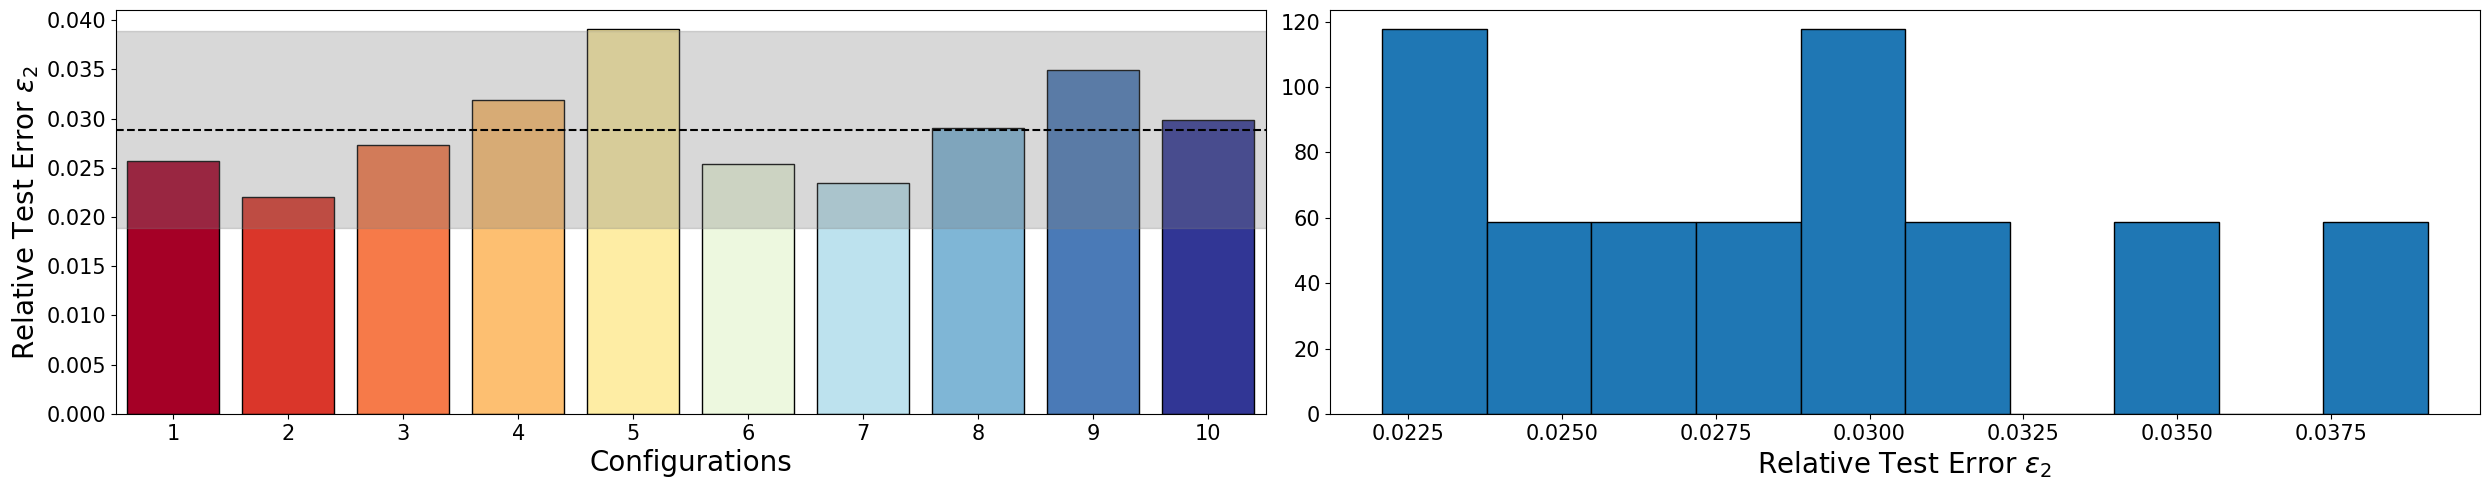

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(25,5))

# Bars
axs[0].bar(np.arange(1, n_configurations+1, 1), relative_test_errors, 
        color = cm.RdYlBu(np.linspace(0,1,len(relative_test_errors))),
        edgecolor='k')
axs[0].axhline(np.mean(relative_test_errors), color='k', linestyle='--', label='Mean Error')
axs[0].fill_between(np.arange(-5, n_configurations+5, 1),
                    np.mean(relative_test_errors) - 2*np.std(relative_test_errors),
                    np.mean(relative_test_errors) + 2*np.std(relative_test_errors),
                    color='gray', alpha=0.3, label='2 Std Dev')

axs[0].set_xlim(0.5, n_configurations+0.5)
axs[0].set_xticks(np.arange(1, n_configurations+1, 1))
axs[0].set_xlabel(r'Configurations', fontsize=20)
axs[0].set_ylabel(r'Relative Test Error $\varepsilon_{2}$', fontsize=20)

# Histogram
axs[1].hist(relative_test_errors, edgecolor='k', density=True)
axs[1].set_xlabel(r'Relative Test Error $\varepsilon_{2}$', fontsize=20)

[ax.tick_params(axis='both', labelsize=15) for ax in axs]

plt.tight_layout()

Let us reshape the output of the SHRED models and the associated test data to simplify the access to the variables.


In [39]:
reshaped_test_out = sc.inverse_transform(test_datasets[0]['Y'].detach().cpu().numpy())[:, num_sensors:]

reshaped_test_pred = {
    'mean': sc.inverse_transform(Ytest_POD_pred['mean'].detach().cpu().numpy())[:, num_sensors:],
    'std': (sc.inverse_transform(Ytest_POD_pred['std'].detach().cpu().numpy()) - sc.data_min_)[:, num_sensors:],
    'full': np.array([sc.inverse_transform(Ytest_POD_hat[kk].detach().cpu().numpy())[:, num_sensors:] for kk in range(n_configurations)])
}
reshaped_test_pred['cov'] = np.zeros((reshaped_test_pred['mean'].shape[0], sum(Nmodes), sum(Nmodes)))
alpha_scaler = np.diag((sc.data_max_ - sc.data_min_)[num_sensors:])
for _tt in range(reshaped_test_pred['mean'].shape[0]):
    reshaped_test_pred['cov'][_tt] = alpha_scaler @ Ytest_POD_pred['cov'][_tt].detach().cpu().numpy()[num_sensors:, num_sensors:] @ alpha_scaler.T

Let us store the reshaped data for 

### Uncertainty Quantification
Let us plot the reconstruction of the POD coefficient with associated standard deviation

In [10]:
for field_i in range(len(var_names)):

    print('Plotting SHRED UQ results for variable: '+var_names[field_i])

    nrows = 2
    ncols = 5
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(6 * ncols, 5 * nrows))
    axs = axs.flatten()

    colors = cm.jet([0.1, 0.25, 0.9])
    ls = 2

    for rr in range(Nmodes[field_i]):
        
        mode = field_i * Nmodes[field_i] + rr
        
        axs[rr].plot(new_t[test_indices+lags], reshaped_test_pred['mean'][:, mode], c=colors[0], label=r'Mean Prediction', linewidth=ls)
        axs[rr].fill_between(new_t[test_indices+lags], 
                                y1 = reshaped_test_pred['mean'][:, mode] - 1.96 * reshaped_test_pred['std'][:, mode],
                                y2 = reshaped_test_pred['mean'][:, mode] + 1.96 * reshaped_test_pred['std'][:, mode],
                                color=colors[1], alpha=0.3, label=r'95\% Confidence Interval')

        axs[rr].plot(new_t[test_indices+lags], reshaped_test_out[:, mode], '--', c=colors[2], label=r'Ground Truth', linewidth=ls)
        axs[rr].set_ylabel(r'$v_{'+str(rr+1)+'}^{'+tex_var_names[field_i]+r'}$', fontsize=20)
        axs[rr].grid()

        axs[rr].set_xlim(min(times), max(times))
        # axs[rr].legend(fontsize=20)
        axs[rr].tick_params(axis='both', labelsize=15)

    Line, Label = axs[0].get_legend_handles_labels()
    fig.legend(Line, Label, fontsize=25, ncols=3, framealpha=1, loc=(0.2, 0.9325))

    axs = axs.reshape(nrows, ncols)
    [ax.set_xlabel(r'Time $t$ (s)', fontsize=20) for ax in axs[1]]

    fig.subplots_adjust(hspace=0.05, top = 0.925, wspace=0.4)
    fig.savefig(path_test+'SHRED_output_uq_'+var_names[field_i]+'.pdf', format='pdf', dpi=250, bbox_inches='tight')
    plt.close(fig)
    

Plotting SHRED UQ results for variable: flux1
Plotting SHRED UQ results for variable: flux2
Plotting SHRED UQ results for variable: flux3
Plotting SHRED UQ results for variable: flux4
Plotting SHRED UQ results for variable: flux5
Plotting SHRED UQ results for variable: flux6
Plotting SHRED UQ results for variable: prec1
Plotting SHRED UQ results for variable: prec2
Plotting SHRED UQ results for variable: prec3
Plotting SHRED UQ results for variable: prec4
Plotting SHRED UQ results for variable: prec5
Plotting SHRED UQ results for variable: prec6
Plotting SHRED UQ results for variable: prec7
Plotting SHRED UQ results for variable: prec8
Plotting SHRED UQ results for variable: dec1
Plotting SHRED UQ results for variable: dec2
Plotting SHRED UQ results for variable: dec3
Plotting SHRED UQ results for variable: T
Plotting SHRED UQ results for variable: p
Plotting SHRED UQ results for variable: U


Let us plot the covariance matrix for the POD coefficients

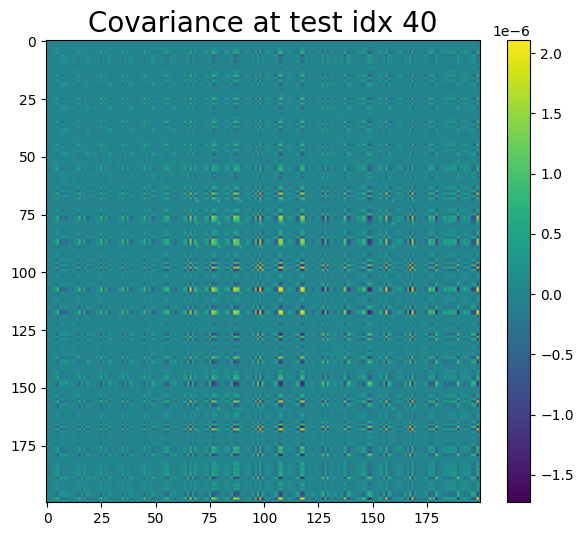

In [40]:
from IPython.display import clear_output as clc

sampling = 10
for mm in range(sampling-1, reshaped_test_pred['cov'].shape[0], sampling):

    fig, axs = plt.subplots(1,1,figsize=(7,6))

    c = axs.imshow(reshaped_test_pred['cov'][mm], cmap='viridis', aspect='auto')
    fig.colorbar(c, ax=axs)
    
    axs.set_title('Covariance at test idx %d' % (mm+1), fontsize=20)

    plt.show()
    clc(wait=True)
    plt.close(fig)

Let us plot the first 5 temporal dynamical the reduced coefficients for each field

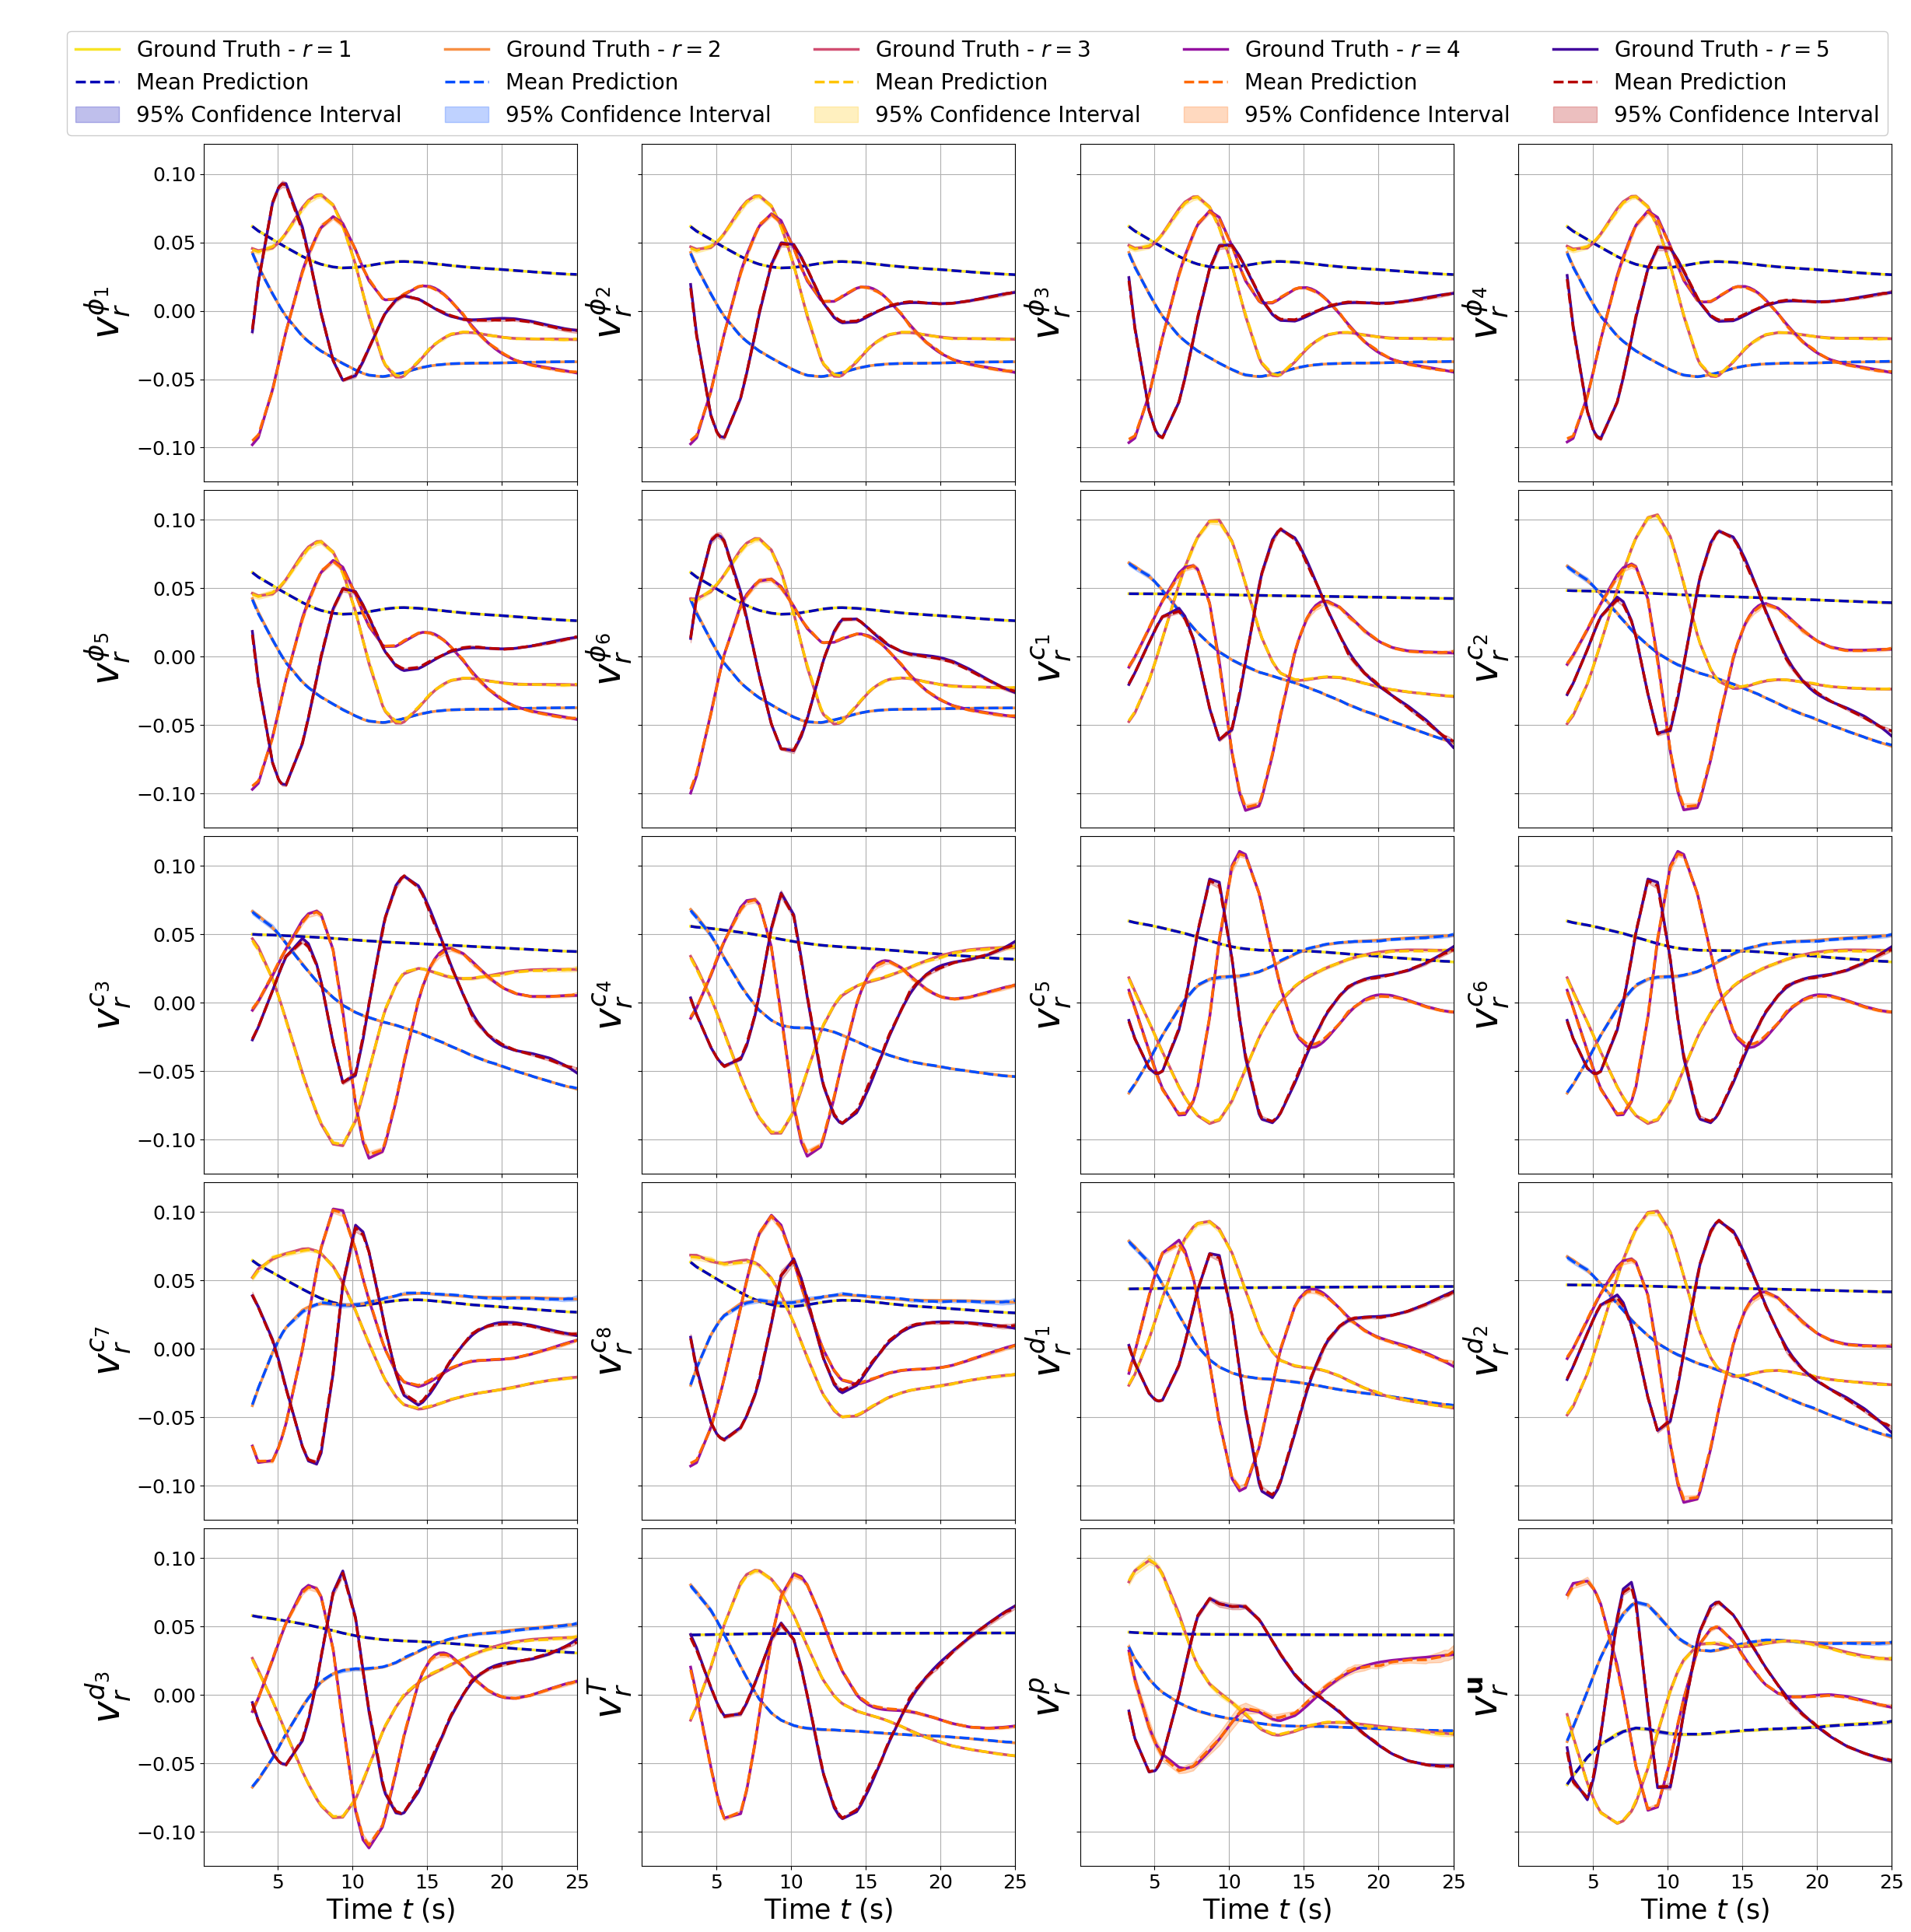

In [41]:
modes_to_plot = 5
    
nrows = 5
ncols = 4
fig, axs = plt.subplots(nrows = nrows, ncols=ncols, sharex=True, sharey=True, figsize=(7 * ncols, 5.5 * nrows))
axs = axs.flatten()

ls = 2.5

for field_i, field in enumerate(var_names):

    idx_to_plot = np.arange(sum(Nmodes[:field_i]),
                            modes_to_plot + sum(Nmodes[:field_i]),
                            1, 
                            dtype=int)

    # colors = cm.jet(np.linspace(0.,1,len(idx_to_plot)))
    colors = cm.jet([0.05, 0.2, 0.7, 0.8, 0.95])
    colors_gt = cm.plasma(np.linspace(0.1,0.95,len(idx_to_plot)))
    for ii, idx in enumerate(idx_to_plot):
        axs[field_i].plot(new_t[test_indices+lags], reshaped_test_out[:, idx], '-', linewidth=ls, c=colors_gt[-1-ii], label=r'Ground Truth - $r='+str(ii+1)+'$')

        axs[field_i].plot(new_t[test_indices+lags], reshaped_test_pred['mean'][:, idx], '--', c=colors[ii], label=r'Mean Prediction', linewidth=ls)
        axs[field_i].fill_between(  new_t[test_indices+lags], 
                                    y1 = reshaped_test_pred['mean'][:, idx] - 1.96 * reshaped_test_pred['std'][:, idx],
                                    y2 = reshaped_test_pred['mean'][:, idx] + 1.96 * reshaped_test_pred['std'][:, idx],
                                    color=colors[ii], alpha=0.25, label=r'95% Confidence Interval')

    axs[field_i].set_ylabel(r'$v_r^{'+tex_var_names[field_i]+r'}$', fontsize=35)
    axs[field_i].grid()

    axs[field_i].set_xticks(np.arange(0,25.0001, 5))
    axs[field_i].set_xlim(min(times), max(times))
    axs[field_i].tick_params(axis='both', labelsize=18)
    # axs[field_i].legend(loc=(1.025, 0.35), ncols=2)
    
Line, Label = axs[0].get_legend_handles_labels()
fig.legend(Line, Label, fontsize=20, ncols=5, framealpha=1, loc=(0.035, 0.93))

axs = axs.reshape(nrows, ncols)
[ax.set_xlabel(r'Time $t$ (s)', fontsize=25) for ax in axs[-1]]

fig.subplots_adjust(hspace=0.025, top = 0.915, wspace=0.175)
fig.savefig(path_test+'SHRED_dynamics_uq.pdf', format='pdf', dpi=250, bbox_inches='tight')

### Decoding to Full Order

In this last section, the output of the SHRED network $\hat{\mathbf{v}}$ is used to estimate the field of interest, using the decoding from the Singular Value Decomposition.

**Some notes on the decoding process with uncertainty quantification.**
Given $\mathbf{v}(t; \boldsymbol{\mu})\in\mathbb{R}^{r\cdot N_{fields}}$ be POD coefficients for all the fields rescaled between 0 and 1, at time $t$ and for parameter $\boldsymbol{\mu}$, the ensemble of SHRED models provides a Gaussian distribution for each POD coefficient:
\begin{equation*}
\mathbf{v}(t; \boldsymbol{\mu}) \sim \mathcal{N}(\overline{\mathbf{v}}(t; \boldsymbol{\mu}), \Sigma_v(t; \boldsymbol{\mu}))
\end{equation*}
where $\overline{\mathbf{v}}(t; \boldsymbol{\mu})$ is the mean vector and $\Sigma_v(t; \boldsymbol{\mu})$ is the covariance matrix.

Since the data predicted by SHRED is between the range $[0, 1]$, where the scaling process is as follows:
\begin{equation*}
\mathbf{v}(t; \boldsymbol{\mu}) = \mathbb{A}^{-1}\cdot \left(\mathbf{b}(t; \boldsymbol{\mu}) - \mathbf{b}_{min}\right), \qquad
\mathbb{A} = diag(\mathbf{b}_{max} - \mathbf{b}_{min})
\end{equation*}
where $\mathbf{b}(t; \boldsymbol{\mu})$ are the POD coefficients rescaled to the original range, $b_{max}$ and $b_{min}$ are the maximum and minimum values of the POD coefficients over the training set.

The inverse transformation provides:
\begin{equation*}
\mathbf{b}(t; \boldsymbol{\mu}) = \mathbb{A}\cdot \mathbf{v}(t; \boldsymbol{\mu}) + \mathbf{b}_{min}
\end{equation*}
this same transformation can be applied to the mean but for the covariance matrix:
\begin{equation*}
\Sigma_b(t; \boldsymbol{\mu}) = \mathbb{A}\cdot \Sigma_v(t; \boldsymbol{\mu}) \cdot \mathbb{A}^T
\end{equation*}
and for the standard deviation:
\begin{equation*}
\sigma_b(t; \boldsymbol{\mu}) =diag(\Sigma_b(t; \boldsymbol{\mu}))^{1/2}= diag(\Sigma_v(t; \boldsymbol{\mu}))^{1/2} * diag(\mathbb{A}) 
\end{equation*}
where $*$ indicates the element-wise multiplication. In this way, it is possible to obtain an estimate for the standard deviation of the POD coefficients in the original scale.

Finally, the POD coefficients are decoded to the full order model as follows:
\begin{equation*}
\mathbf{u}(t; \boldsymbol{\mu}) = \Phi \cdot \mathbf{b}(t; \boldsymbol{\mu})
\end{equation*}
where $\Phi \in \mathbb{R}^{\mathcal{N}_h\times r\cdot N_{fields}}$ is a block POD basis matrix, where each block corresponds to the POD basis of each field, defined as follows:
\begin{equation*}
\Phi =
\begin{bmatrix}
\Phi_1 & 0 & \cdots & 0 \\
0 & \Phi_2 & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & \Phi_{N_{fields}}
\end{bmatrix}
\end{equation*}
where $\Phi_i \in \mathbb{R}^{\mathcal{N}_h\times r}$ is the POD basis for the $i$-th field.

The covariance matrix for the high-dimensional state (considering all the fields) can be estimated as:
\begin{equation*}
\Sigma_u(t; \boldsymbol{\mu}) = \Phi \cdot \Sigma_b(t; \boldsymbol{\mu}) \cdot \Phi^T
\end{equation*}
Due to the block structure of $\Phi$, each block of $\Sigma_u$ corresponds to the covariance matrix of each field as follows:
\begin{equation*}
\Sigma_u(t; \boldsymbol{\mu}) =
\begin{bmatrix}
\Phi_1 \cdot \Sigma_b(t; \boldsymbol{\mu}) \cdot \Phi_1^T & \Phi_1 \cdot \Sigma_b(t; \boldsymbol{\mu}) \cdot \Phi_2^T & \cdots & \Phi_1 \cdot \Sigma_b(t; \boldsymbol{\mu}) \cdot \Phi_{N_{fields}}^T \\
\Phi_2 \cdot \Sigma_b(t; \boldsymbol{\mu}) \cdot \Phi_1^T & \Phi_2 \cdot \Sigma_b(t; \boldsymbol{\mu}) \cdot \Phi_2^T & \cdots & \Phi_2 \cdot \Sigma_b(t; \boldsymbol{\mu}) \cdot \Phi_{N_{fields}}^T \\
\vdots & \vdots & \ddots & \vdots \\
\Phi_{N_{fields}} \cdot \Sigma_b(t; \boldsymbol{\mu}) \cdot \Phi_1^T & \Phi_{N_{fields}} \cdot \Sigma_b(t; \boldsymbol{\mu}) \cdot \Phi_2^T & \cdots & \Phi_{N_{fields}} \cdot \Sigma_b(t; \boldsymbol{\mu}) \cdot \Phi_{N_{fields}}^T
\end{bmatrix}
\end{equation*}

Since the storage of the full covariance matrix is not feasible for high-dimensional systems, it is not efficient to compute it completely.

Given $\Psi_i$ as the POD basis for the $i$-th field and $\Sigma_b$ as the covariance matrix of the POD coefficients, we want to compute only the diagonal of the covariance matrix for the $i$-th field, which can be computed as:
\begin{equation*}
diag(\Sigma_{u_i}(t; \boldsymbol{\mu})) = diag(\Psi_i \cdot \Sigma_b(t; \boldsymbol{\mu}) \cdot \Psi_i^T) = \sum_{k=1}^{r} (\Psi_i)_{:,k}^2 \cdot (\Sigma_b(t; \boldsymbol{\mu}))_{k,k}
\end{equation*}
where $(\Psi_i)_{:,k}$ is the $k$-th column of the POD basis $\Psi_i$ and $(\Sigma_b(t; \boldsymbol{\mu}))_{k,k}$ is the $k$-th diagonal element of the covariance matrix of the POD coefficients.

Using `torch` operations, this can be efficiently computed as follows.

In [ ]:
field_i = 0
field = var_names[field_i]
idx_to_recon = np.arange(sum(Nmodes[:field_i]),  sum(Nmodes[:field_i+1]),  1, dtype=int)

u_ = u_total[var_names[field_i]]
s_ = np.diag(s_total[var_names[field_i]])

_U = torch.from_numpy((u_ @ s_).astype(np.float32)).to(device)
_C  = torch.from_numpy(reshaped_test_pred['cov'][:, sum(Nmodes[:field_i]) : sum(Nmodes[:field_i+1]), sum(Nmodes[:field_i]) : sum(Nmodes[:field_i+1])].astype(np.float32)).to(device)
recon_std_from_cov_torch = torch.einsum("ir,trs,is->ti", _U, _C, _U).cpu().detach().numpy().T * (rescaling_snaps[field_i]**2)

Alternatively, the standard deviation can be computed directly from the predicted high-dimensional state using the proper estimator.

In [ ]:
v_mean = reshaped_test_pred['mean'][:, sum(Nmodes[:field_i]) : sum(Nmodes[:field_i+1])]
v_full = np.array([reshaped_test_pred['full'][kk,:, sum(Nmodes[:field_i]) : sum(Nmodes[:field_i+1])] for kk in range(n_configurations)])

recon_mean = (u_ @ s_ @ v_mean.T) * rescaling_snaps[field_i]

recon_std_full = np.zeros((u_.shape[0], v_mean.shape[0]))
for kk in range(n_configurations):
    recon_kk = (u_ @ s_ @ v_full[kk].T) * rescaling_snaps[field_i]
    recon_std_full += (recon_kk - recon_mean)**2 / (n_configurations - 1)
recon_std_full = np.sqrt(recon_std_full / n_configurations)

Let us plot the standard deviations obtained with the different approaches for a given parameter and position

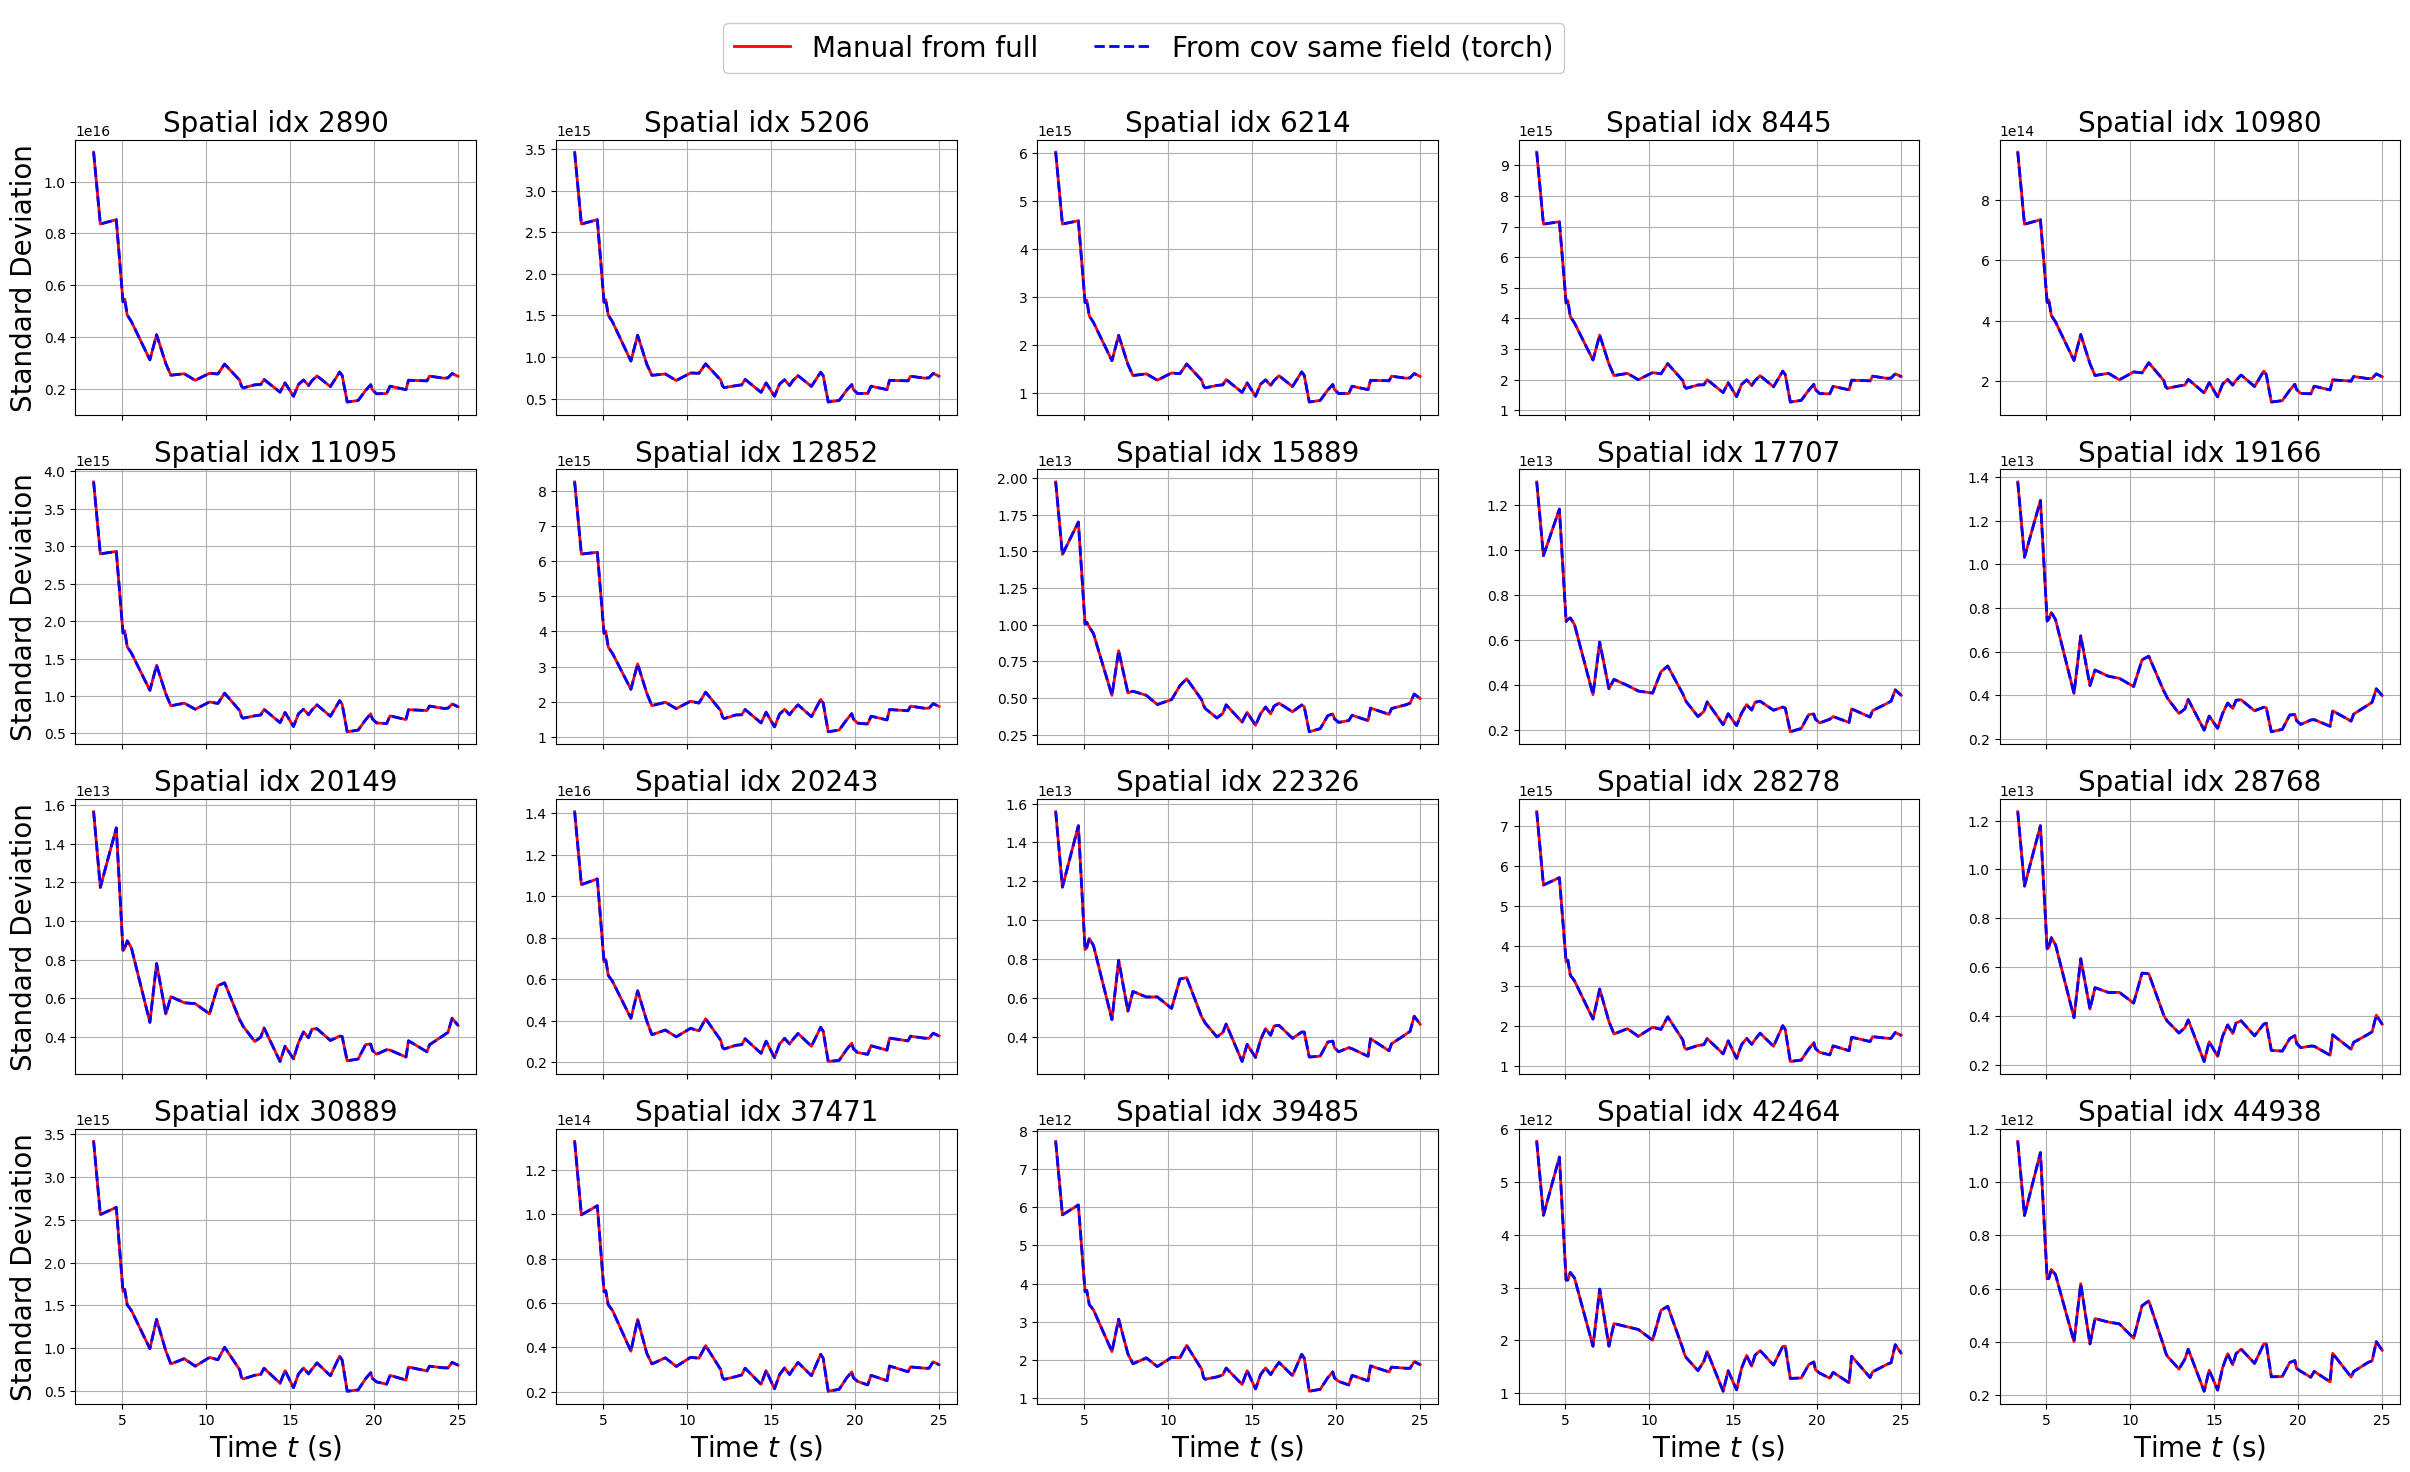

In [84]:
spatial_idxs = np.sort(np.random.choice(recon_std_full.shape[0], size=20, replace=False))
param_to_plot = 0

nrows = 4
ncols = len(spatial_idxs) // nrows
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4 * nrows), sharex=True)
axs = axs.flatten()

for i, spatial_idx in enumerate(spatial_idxs):
    axs[i].plot(times[test_indices+lags], recon_std_full[spatial_idx], 'r', label='Manual from full', linewidth=2)
    axs[i].plot(times[test_indices+lags], np.sqrt(recon_std_from_cov_torch[spatial_idx]), 'b--', label='From cov same field (torch)', linewidth=2)

    axs[i].grid()
    axs[i].set_title(f'Spatial idx {spatial_idx}', fontsize=20)

    if i >= (nrows * (ncols - 1) - 1):
        axs[i].set_xlabel(r'Time $t$ (s)', fontsize=20)

    if i % ncols == 0:
        axs[i].set_ylabel(r'Standard Deviation', fontsize=20)

_line, _label = axs[0].get_legend_handles_labels()
fig.legend(_line, _label, fontsize=20, ncols=2, framealpha=1, loc=(0.3, 0.95))

fig.subplots_adjust(top=0.9)

Let us compute some average quantities, related to the average temperature and the core power.

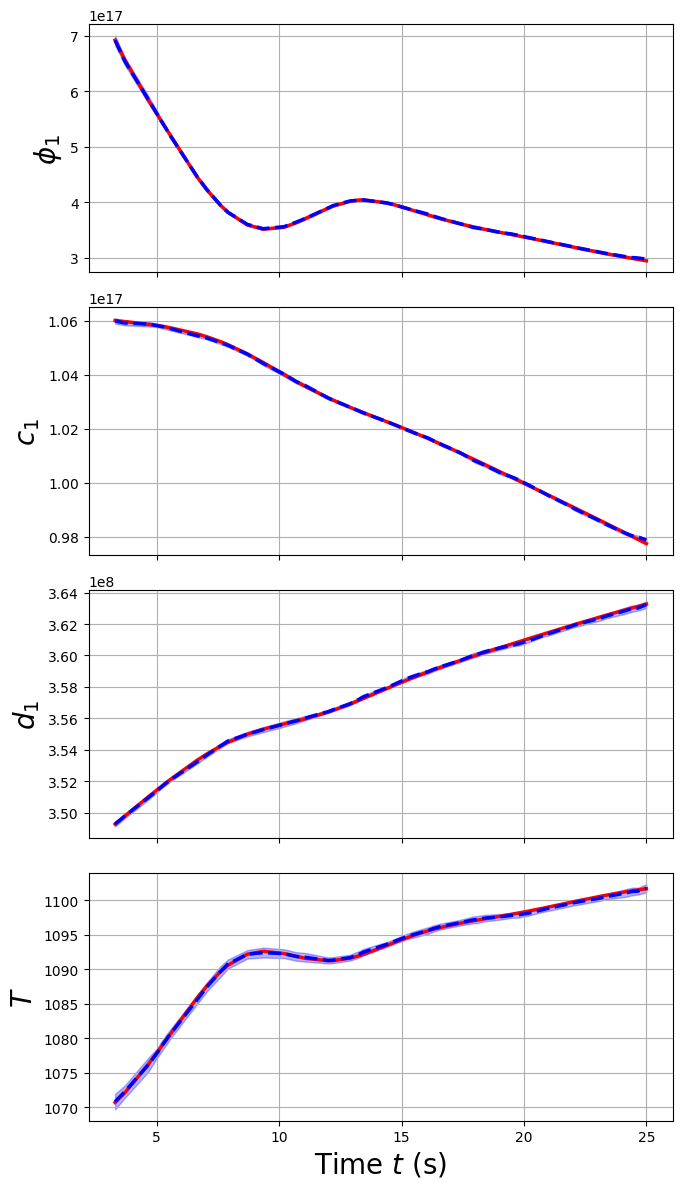

In [19]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

fields_to_plot = [0, 6, 14, 17] # temperature and flux

fig, axs = plt.subplots(nrows = len(fields_to_plot), ncols = 1, sharex = True, figsize = (7, 3 * len(fields_to_plot)))

cmap = cm.RdYlGn
ls = 2.5

for ii, field_i in enumerate(fields_to_plot):

    v_truth = reshaped_test_out[:, sum(Nmodes[:field_i]) : sum(Nmodes[:field_i+1])]
    v_mean = reshaped_test_pred['mean'][:, sum(Nmodes[:field_i]) : sum(Nmodes[:field_i+1])]
    v_full = np.array([reshaped_test_pred['full'][kk,:, sum(Nmodes[:field_i]) : sum(Nmodes[:field_i+1])] for kk in range(n_configurations)])

    u_ = u_total[var_names[field_i]]
    s_ = np.diag(s_total[var_names[field_i]])

    fom = (u_ @ s_ @ v_truth.T) * rescaling_snaps[field_i]
    recon = (u_ @ s_ @ v_mean.T) * rescaling_snaps[field_i]
    std_recon = np.zeros_like(recon)
    for kk in range(n_configurations):
        recon_kk = (u_ @ s_ @ v_full[kk].T) * rescaling_snaps[field_i]
        std_recon += (recon_kk - recon)**2 / (n_configurations - 1)
    std_recon = np.sqrt(std_recon) / np.sqrt(n_configurations)

    axs[ii].plot(new_t[test_indices+lags], fom.mean(axis=0), c='r', label=r'Ground Truth', linewidth=ls)
    axs[ii].plot(new_t[test_indices+lags], recon.mean(axis=0), '--', c='b', label=r'Mean Prediction', linewidth=ls)
    axs[ii].fill_between(new_t[test_indices+lags],
                        y1 = recon.mean(axis=0) - 1.96 * std_recon.mean(axis=0),
                        y2 = recon.mean(axis=0) + 1.96 * std_recon.mean(axis=0),
                        color='b', alpha=0.3, label=r'95\% Confidence Interval')

    axs[ii].set_ylabel(r'$'+tex_var_names[field_i]+r'$', fontsize=20)
    axs[ii].grid()

axs[-1].set_xlabel(r'Time $t$ (s)', fontsize=20)

plt.tight_layout()


Let us compute the average relative error for generic field $u$ as
\begin{equation*}
\varepsilon_u = \frac{1}{T}\sum_{t=1}^T \frac{\| u_t - \hat{u}_t\|_2}{\| u_t\|_2}
\end{equation*}
given $\hat{u}_t$ the reconstruction at time $t$ (using mean POD coefficients).

In [85]:
Ns_test = reshaped_test_out.shape[0]

ave_rel_errors = np.zeros((Nvariables, Ns_test))

for field_i in range(Nvariables):

    v_truth = reshaped_test_out[:, sum(Nmodes[:field_i]) : sum(Nmodes[:field_i+1])]
    u_ = u_total[var_names[field_i]]
    s_ = np.diag(s_total[var_names[field_i]])

    fom = (u_ @ s_ @ v_truth.T) * rescaling_snaps[field_i]

    v_shred = reshaped_test_pred['mean'][:, sum(Nmodes[:field_i]) : sum(Nmodes[:field_i+1])]
    prediction = (u_ @ s_ @ v_shred.T) * rescaling_snaps[field_i]
    
    ave_rel_errors[field_i] = np.linalg.norm(fom - prediction, axis=0) / np.linalg.norm(fom, axis=0)
    
    print("Average relative error for variable %s: %s." % (var_names[field_i],
          num2p(ave_rel_errors[field_i,:].mean())))

Average relative error for variable flux1: 0.20%.
Average relative error for variable flux2: 0.18%.
Average relative error for variable flux3: 0.17%.
Average relative error for variable flux4: 0.23%.
Average relative error for variable flux5: 0.19%.
Average relative error for variable flux6: 0.15%.
Average relative error for variable prec1: 0.03%.
Average relative error for variable prec2: 0.05%.
Average relative error for variable prec3: 0.08%.
Average relative error for variable prec4: 0.15%.
Average relative error for variable prec5: 0.23%.
Average relative error for variable prec6: 0.25%.
Average relative error for variable prec7: 0.28%.
Average relative error for variable prec8: 0.23%.
Average relative error for variable dec1: 0.02%.
Average relative error for variable dec2: 0.03%.
Average relative error for variable dec3: 0.20%.
Average relative error for variable T: 0.03%.
Average relative error for variable p: 0.02%.
Average relative error for variable U: 1.31%.


Let us plot the errors using bar plots

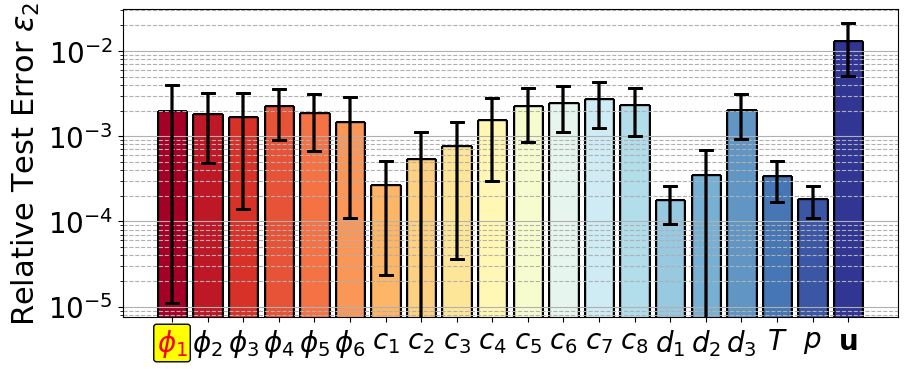

In [87]:
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize=(10,4))

colors = cm.jet(np.linspace(0,1, len(var_names)))
for field_i in range(len(var_names)):
    # axs.scatter(field_i , np.mean(ave_rel_errors.mean(axis=1), axis=1)[field_i], color=colors[field_i])
    axs.bar(np.arange(1, len(var_names)+1, 1), np.mean(ave_rel_errors, axis=1), 
            yerr = ave_rel_errors.std(axis=1), capsize=5,
            color = cm.RdYlBu(np.linspace(0,1,len(var_names))),
            edgecolor='k')

axs.set_yscale('log')
axs.set_xticks(np.arange(1,len(var_names)+1,1), ['$'+tex_+'$' for tex_ in tex_var_names])
# axs.set_yticks(np.arange(0,0.1,0.01))

# Highlight the tick label at measured field
xticks = axs.get_xticklabels()
xticks[0].set_color('red')
xticks[0].set_bbox(dict(facecolor='yellow', edgecolor='black', boxstyle='round,pad=0.1'))

axs.tick_params(axis='both', labelsize=20)
axs.set_ylabel(r'Relative Test Error $\varepsilon_{2}$', fontsize=22)
axs.grid(axis='y', linestyle='-')
axs.grid(axis='y', which='minor', linestyle='--')

fig.savefig(path_test+'fom_relativerrror_bars.pdf', format='pdf', dpi=250, bbox_inches='tight')

Let us compute the average relative error for generic field $u$ for each configuration as
\begin{equation*}
\varepsilon_u = \frac{1}{T}\sum_{t=1}^T \frac{\| u_t - \hat{u}_t^{(l)}\|_2}{\| u_t\|_2}
\end{equation*}
given $\hat{u}_t^{(l)}$ the reconstruction at time $t$ using the $l$-th configuration of the SHRED model and $T$ the trajectory length.

In [89]:
Ns_test = reshaped_test_out.shape[0]

ave_rel_errors = np.zeros((Nvariables, Ns_test, n_configurations))

for field_i in range(Nvariables):

    v_truth = reshaped_test_out[:, sum(Nmodes[:field_i]) : sum(Nmodes[:field_i+1])]
    u_ = u_total[var_names[field_i]]
    s_ = np.diag(s_total[var_names[field_i]])

    fom = (u_ @ s_ @ v_truth.T) * rescaling_snaps[field_i]

    for kk in range(n_configurations):
        v_shred = reshaped_test_pred['full'][kk,:, sum(Nmodes[:field_i]) : sum(Nmodes[:field_i+1])]
        prediction = (u_ @ s_ @ v_shred.T) * rescaling_snaps[field_i]

        ave_rel_errors[field_i, :, kk] = np.linalg.norm(fom - prediction, axis=0) / np.linalg.norm(fom, axis=0)

Let us plot the heat maps of the average relative errors for each configuration

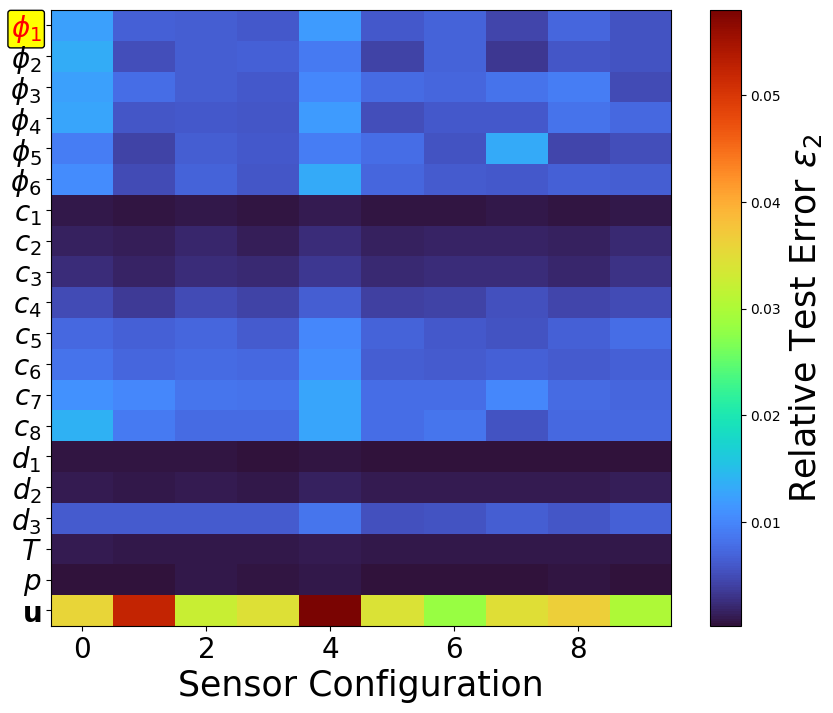

In [91]:
fig, axs = plt.subplots(figsize=(10,8))

heat_map = axs.imshow(ave_rel_errors.mean(axis=1), cmap=cm.turbo, aspect='auto')
axs.set_xlabel(r'Sensor Configuration', fontsize=25)
axs.set_yticks(np.arange(len(var_names)), labels=['$'+tex_+'$' for tex_ in tex_var_names])
axs.tick_params(axis='both', labelsize=20)
cbar = plt.colorbar(heat_map)
cbar.set_label(r'Relative Test Error $\varepsilon_{2}$', fontsize=25)

# Highlight the tick label at measured field
yticks = axs.get_yticklabels()
yticks[0].set_color('red')
yticks[0].set_bbox(dict(facecolor='yellow', edgecolor='black', boxstyle='round,pad=0.1'))


### Contour Plots
Let us load the mesh. Unfortunately, there is a missing node in the mesh file so the plot might look weird,  sorry about this, but it is probably a problem with different versions of pyvista/vtk and gmsh.

In [230]:
import pyvista as pv
from plots import *

grid = pv.read('./evol_mesh.vtk')

# pl = pv.Plotter()
# pl.add_mesh(grid, color='white', opacity=0.3, show_edges=True)
# pl.view_xy()
# pl.show(jupyter_backend='static')

# Adding the missing node at the origin to make dimensions match
nodes = np.concatenate([grid.points, np.zeros((1, 3))], axis=0)

Let us make a plot for some fields

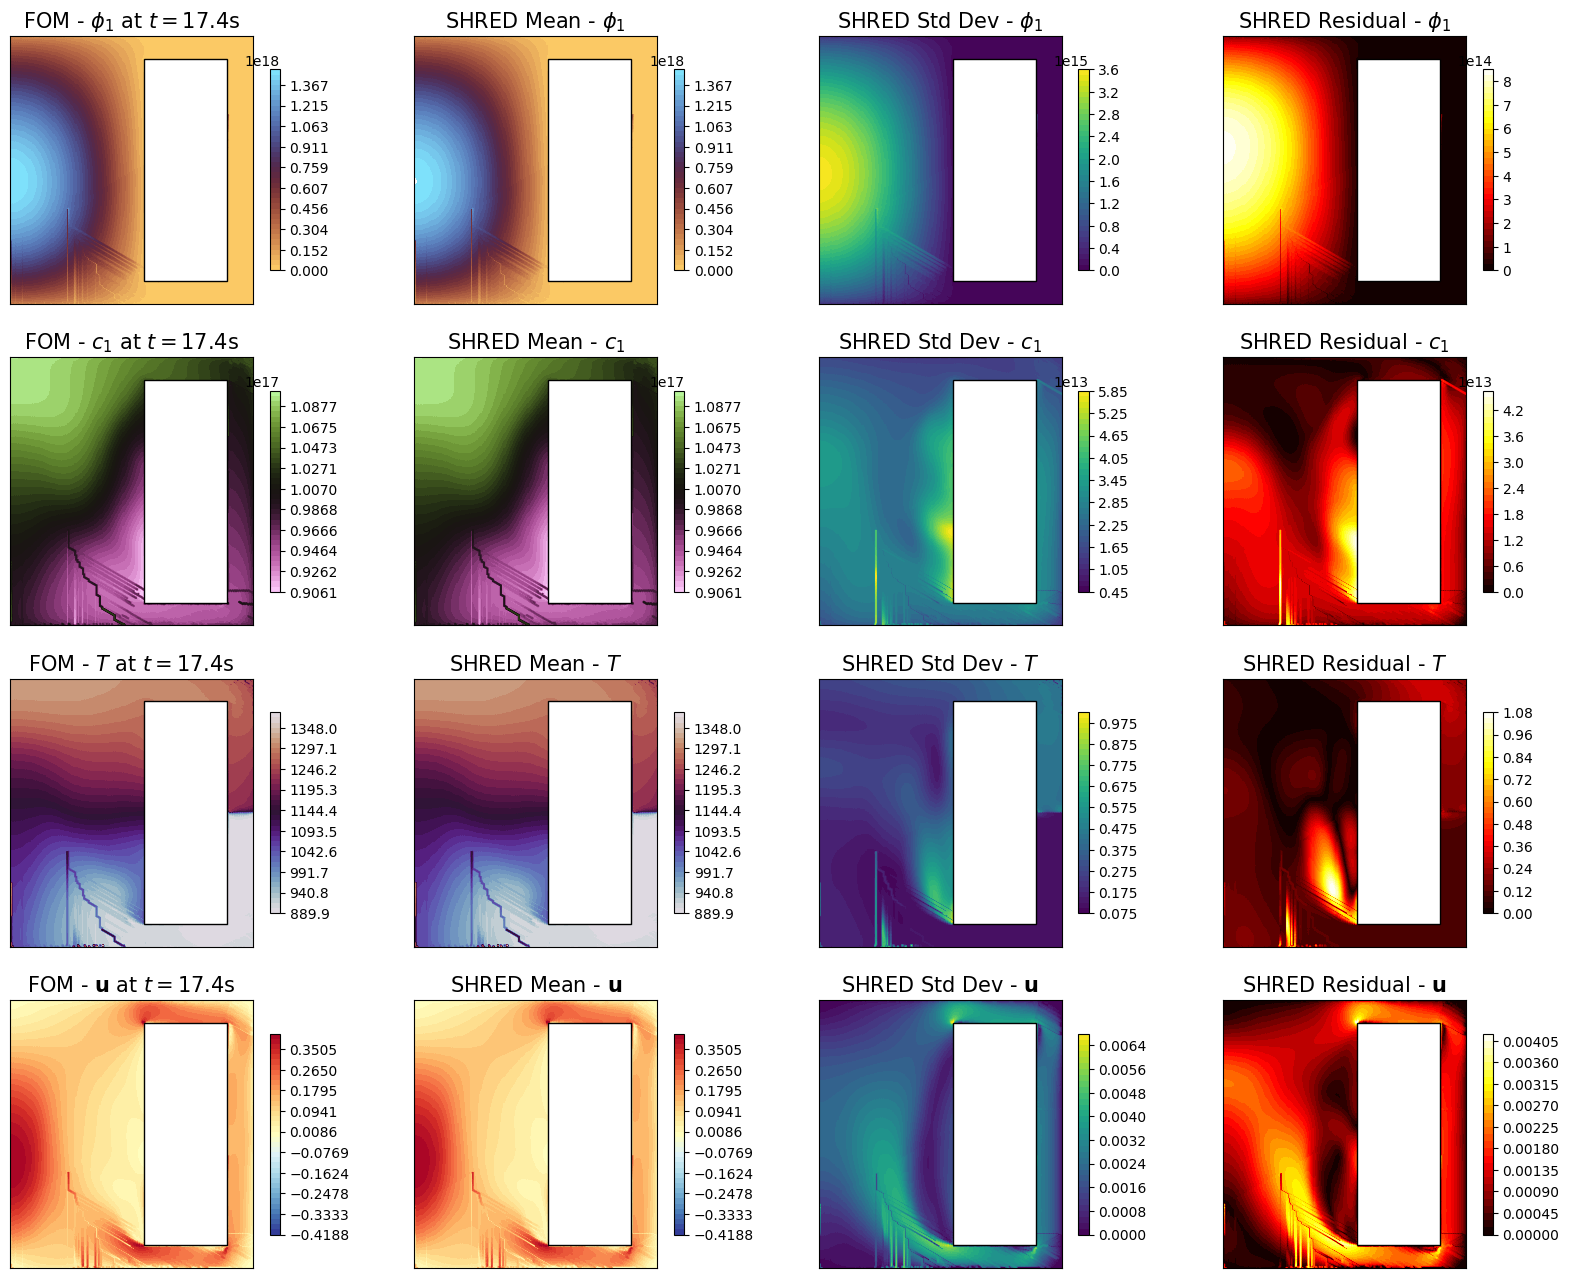

In [227]:
fields_to_plot = [0, 6, 17, 19]
tt = 30
cmaps = [
    'managua',
    'vanimo',
    'twilight',
    'RdYlBu_r'
]

nrows = len(fields_to_plot)
ncols = 4

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows))

for ii, field_i in enumerate(fields_to_plot):

    vec_mode_to_plot = 'Mag' if field_i == 19 else None

    # FOM
    v_truth = reshaped_test_out[:, sum(Nmodes[:field_i]) : sum(Nmodes[:field_i+1])]
    u_ = u_total[var_names[field_i]]
    s_ = np.diag(s_total[var_names[field_i]])
    fom = (u_ @ s_ @ v_truth.T) * rescaling_snaps[field_i]
    fom = fom[:, tt]
    levels = np.linspace(fom.min(), fom.max(), 40)

    # Mean SHRED
    v_shred = reshaped_test_pred['mean'][:, sum(Nmodes[:field_i]) : sum(Nmodes[:field_i+1])]
    prediction = (u_ @ s_ @ v_shred.T) * rescaling_snaps[field_i]
    prediction = prediction[:, tt]

    # Std SHRED
    v_full = np.array([reshaped_test_pred['full'][kk, tt, sum(Nmodes[:field_i]) : sum(Nmodes[:field_i+1])] for kk in range(n_configurations)])
    std_recon = np.zeros_like(prediction)
    for kk in range(n_configurations):
        recon_kk = (u_ @ s_ @ v_full[kk].T) * rescaling_snaps[field_i]
        std_recon += (recon_kk - prediction)**2 / (n_configurations - 1)
    std_recon = np.sqrt(std_recon) / np.sqrt(n_configurations)

    # Residual
    residual = np.abs(fom - prediction)

    # Plotting
    c = plot_contour(axs[ii, 0], nodes[:, :2], fom, cmap=cmaps[ii], levels = levels, vec_mode_to_plot=vec_mode_to_plot)
    fig.colorbar(c, ax = axs[ii, 0], orientation='vertical', pad=0.05, aspect=20, shrink = 0.75)

    plot_contour(axs[ii, 1], nodes[:, :2], prediction, cmap=cmaps[ii], levels = levels, vec_mode_to_plot=vec_mode_to_plot)
    fig.colorbar(c, ax = axs[ii, 1], orientation='vertical', pad=0.05, aspect=20, shrink = 0.75)

    c = plot_contour(axs[ii, 2], nodes[:, :2], std_recon, cmap='viridis', levels = 40, vec_mode_to_plot=vec_mode_to_plot)
    fig.colorbar(c, ax = axs[ii, 2], orientation='vertical', pad=0.05, aspect=20, shrink = 0.75)


    c = plot_contour(axs[ii, 3], nodes[:, :2], residual, cmap='hot', levels = 40, vec_mode_to_plot=vec_mode_to_plot)
    fig.colorbar(c, ax = axs[ii, 3], orientation='vertical', pad=0.05, aspect=20, shrink = 0.75)

    axs[ii, 0].set_title(r'FOM - $'+tex_var_names[field_i]+r'$ at $t=$'+str(new_t[test_indices+lags][tt])+'s', fontsize=15)
    axs[ii, 1].set_title(r'SHRED Mean - $'+tex_var_names[field_i]+r'$', fontsize=15)
    axs[ii, 2].set_title(r'SHRED Std Dev - $'+tex_var_names[field_i]+r'$', fontsize=15)
    axs[ii, 3].set_title(r'SHRED Residual - $'+tex_var_names[field_i]+r'$', fontsize=15)
